<a href="https://colab.research.google.com/github/Christoph5418/rohedge/blob/main/HedgeInvestments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Packages and Imports

In [ ]:
!pip install robin-stocks
!pip install pyotp
!pip install numpy
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import robin_stocks.robinhood as rs
import pyotp
import sys
import math
import numpy as np
import matplotlib.pyplot as plt

### Robinhood Login Information

In [ ]:
username=''
password=''
login = rs.login(username=username, password=password)

### Constants

In [ ]:
# CONSTANTS
STOCK_INCREMENTS = {"AAPL":2.5, "TSLA":2.5, "AFRM":.5, "SNAP":.5, "NFLX":5,
"SPY":1, "META":2.5, "DIS":1, "SHOP":1, "MSFT":2.5, "GPRO":.5, "SBUX":1,
"F":.5, "BABA":1, "BAC":.5, "GE":1, "AMD":1, "NVDA":5, "AMZN":1, "GOOGL":1,
"QQQ":1, "COIN":1, "LCID":.5, "CVNA":.5, "PFE":.5, "CCL":.5, "KO":1, "UAL":1,
"NOK":.5, "DAL":.5, "GME":.5, "T":.5, "PYPL":1, "UBER":.5, "WMT":2.5, "LUV":.5,
"GM":.5, "BB":.5, "MRNA":1, "RBLX":.5, "SQ":1, "ABNB":1, "BA":2.5, "DKNG":.5,
"INTC":.5, "XOM":1, "JNJ":2.5, "NKE":1, "COST":5, "SONY":1, "V":2.5, "TGT":1,
"VZ":.5, "ZM":1, "BBIG":.5, "AMC":.5, "DWAC":.5, "TEVA":.5, "NVAX":.5,
"INTC":.5,}

STOCK = 'AAPL'
OPTION_INTERVAL = STOCK_INCREMENTS[STOCK]
EXPIRATION_DATE = '2023-06-30'
NUM_OPTIONS = 5
BOUNDARY_PERCENT = 0.1;
NUM_STEPS = 100

# STOCK VARIABLES
stockPrice = -999
stockAdjustedPrice = -999
stockBreakEvenPrices = []
stockAdjustedPutPrices = []
stockBidPrices = []
stockAskPrices = []
stockStrikePrices = []
premiumPL = []
potentialProfits = []

### Methods

In [ ]:
def round_down_to_nearest_option_interval(number):
    rounded_number = math.floor(number / OPTION_INTERVAL) * OPTION_INTERVAL
    return rounded_number

def round_up_to_nearest_option_interval(number):
    rounded_number = math.ceil(number / OPTION_INTERVAL) * OPTION_INTERVAL
    return rounded_number

## Finds rounded price and a list of **strike call prices**

In [ ]:
stockStrikePrices = []
stockPrice = rs.get_latest_price(STOCK)
stockAdjustedPrice = round_down_to_nearest_option_interval(float(stockPrice[0])) #Gets stocks strike prices
display("Rounded Stock Price: " + str(stockAdjustedPrice))
for i in range(0, NUM_OPTIONS):
  stockStrikePrices.append(stockAdjustedPrice + i * OPTION_INTERVAL)
display("Rounded Strike Call Prices: " + str(stockStrikePrices))

'Rounded Stock Price: 185.0'

'Rounded Strike Call Prices: [185.0, 187.5, 190.0, 192.5, 195.0]'

## Finds **put strike prices**, **break even prices**, and **stock bid prices**

In [ ]:
stockBreakEvenPrices = []
stockBidPrices = []
stockAdjustedPutPrices= []
for i in range(NUM_OPTIONS):
  op = rs.get_option_market_data(STOCK,
                      expirationDate= EXPIRATION_DATE,  #Gets break even price
                      strikePrice=stockStrikePrices[i],
                      optionType='call')
  stockBidPrices.append(op[0][0].get('bid_price'))
  stockBreakEvenPrices.append(float(stockPrice[0]) - float(stockBidPrices[i]))
  stockAdjustedPutPrices.append(round_up_to_nearest_option_interval(float(stockPrice[0]) - float(stockBidPrices[i])))
print('Put Strike Prices: ' + str(stockAdjustedPutPrices))
print('Break Even Price: ' + str(stockBreakEvenPrices))

Put Strike Prices: [185.0, 185.0, 187.5, 187.5, 187.5]
Break Even Price: [183.71, 184.93, 185.52, 185.7, 185.76]


## Finds **put ask prices** and **call bid prices**

In [ ]:
stockAskPrices = []
for i in range(NUM_OPTIONS):
  op = rs.get_option_market_data(STOCK,
                      expirationDate= EXPIRATION_DATE,  #Gets put ask price
                      strikePrice=stockAdjustedPutPrices[i],
                      optionType='put')
  stockAskPrices.append(op[0][0].get('ask_price'))

print('Put Ask Prices: ' + str(stockAskPrices))
print('Call Bid Prices: ' + str(stockBidPrices))


Put Ask Prices: ['1.120000', '1.120000', '2.400000', '2.410000', '2.410000']
Call Bid Prices: ['2.070000', '0.850000', '0.260000', '0.080000', '0.020000']


## Finds **profit or los** of premiums

In [ ]:
premiumPL = []
for i in range(NUM_OPTIONS):
  premiumPL.append((float(stockBidPrices[i]) - float(stockAskPrices[i])) * 100)

display('Profit or Loss of Premiums: ' + str(premiumPL))

'Profit or Loss of Premiums: [94.99999999999997, -27.000000000000014, -213.99999999999997, -233.0, -239.0]'

##Profit vs Ending Price of Stock

In [ ]:
OriginalPrice = float(stockPrice[0])

putStrikePrices = np.array(stockAdjustedPutPrices).astype(float);
callStrikePrices = np.array(stockStrikePrices).astype(float);
callPremium = np.array(stockBidPrices).astype(float);
breakEvenPrices = np.array(stockBreakEvenPrices).astype(float);
putPremium = np.array(stockAskPrices).astype(float);

stockEndPricesLinspace = np.linspace(OriginalPrice*(1-BOUNDARY_PERCENT), OriginalPrice*(1+BOUNDARY_PERCENT), num=NUM_STEPS);

profitInt = np.arange(NUM_STEPS*NUM_OPTIONS).reshape((NUM_STEPS, NUM_OPTIONS))
putAndCallProfit = profitInt.astype(float);

for i in range(NUM_OPTIONS):
  for j in range(NUM_STEPS):
    if(stockEndPricesLinspace[j] <= putStrikePrices[i]):
      putAndCallProfit[j][i] = putStrikePrices[i] - (OriginalPrice-callPremium[i]+putPremium[i]);
    elif(stockEndPricesLinspace[j] < callStrikePrices[i]):
      putAndCallProfit[j][i] = (callPremium[i]-putPremium[i])+(stockEndPricesLinspace[j]-OriginalPrice);
    else:
      putAndCallProfit[j][i] = (callPremium[i]-putPremium[i]) + (callStrikePrices[i]-OriginalPrice);
putAndCallProfit = 100.0*putAndCallProfit;

In [ ]:
callProfit = profitInt.astype(float);


for i in range(NUM_OPTIONS):
  for j in range(NUM_STEPS):
    if stockEndPricesLinspace[j] <= callStrikePrices[i]:
      callProfit[j][i] = callPremium[i] - OriginalPrice + stockEndPricesLinspace[j];
    else:
      callProfit[j][i] = callPremium[i] - OriginalPrice + callStrikePrices[i];

callProfit = callProfit*100.0

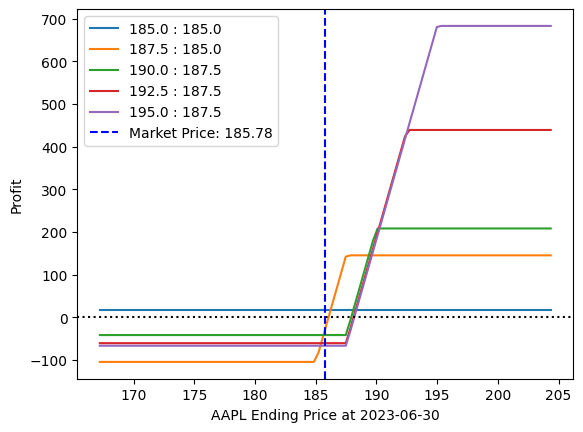

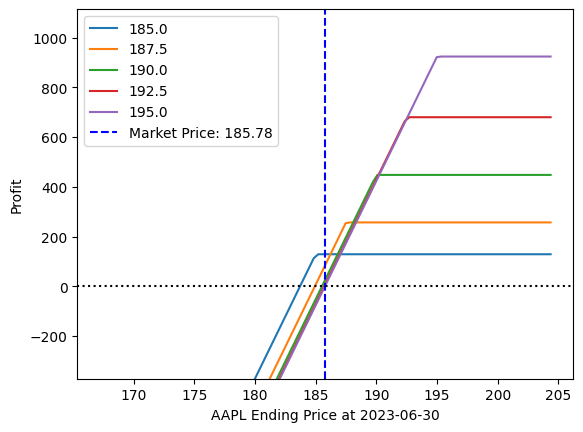

In [ ]:
putAndCallProfitT = np.transpose(putAndCallProfit);

for i in range(NUM_OPTIONS):
  plt.plot(stockEndPricesLinspace, putAndCallProfitT[i], label=str(callStrikePrices[i]) + " : " + str(putStrikePrices[i]));

plt.axvline(x = OriginalPrice, color = 'b', linestyle='dashed', label = "Market Price: " + str(OriginalPrice))
plt.xlabel(STOCK + ' Ending Price at ' + EXPIRATION_DATE);
plt.ylabel('Profit');
plt.axhline(y = 0, color = 'black', linestyle = 'dotted')
plt.legend(loc='best')

plt.show()


print("\n\n\n")

callProfitT = np.transpose(callProfit);

for i in range(NUM_OPTIONS):
  plt.plot(stockEndPricesLinspace, callProfitT[i], label=str(callStrikePrices[i]));

plt.axvline(x = OriginalPrice, color = 'b', linestyle='dashed', label = "Market Price: " + str(OriginalPrice))
plt.xlabel(STOCK + ' Ending Price at ' + EXPIRATION_DATE);
plt.ylabel('Profit');
plt.legend(loc='best')
plt.axhline(y = 0, color = 'black', linestyle = 'dotted')

plt.ylim(OriginalPrice*-2, OriginalPrice *6)


plt.show()